![Head_course.png](./Head_course.png)

## Sección 1. Importación de librerías e imagen

In [8]:
#La siguiente línea *%matplotlib inline* es necesaria para que las imágenes se muestren correctamente dentro de Jupyter Notebook.
%matplotlib inline
#Importanción de librerías
import os
#import argparse
#import matplotlib
import numpy as np
import pandas as pd
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# FLUJO DE TRABAJO PARA CONTAR Y MEDIR SEMILLAS

In [9]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
# %matplotlib widget

In [10]:
#Import libraries
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [11]:
# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.6'

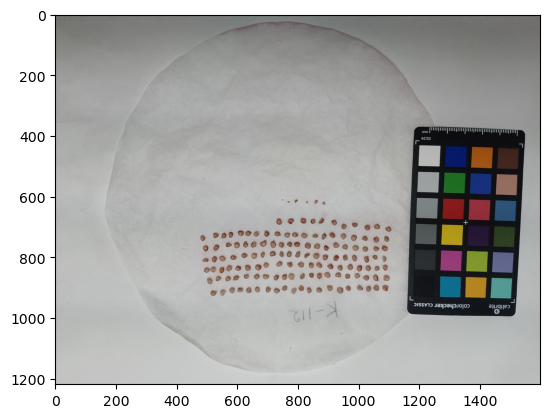

In [12]:
# Opciones de archivos de entrada 
args = WorkflowInputs(
    images=["./K112.jpg"],
    names="image",
    result="./res.csv",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

# Set debug to the global parameter 
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer & # Update params text size
# (size may need to be altered based on original image size)
pcv.params.text_size =18
pcv.params.text_thickness =5


## Change display settings
# pcv.params.dpi = 170
# pcv.params.text_size = 10
# pcv.params.text_thickness = 20

img, path, filename = pcv.readimage(filename=args.image)
#print("Intentando abrir la imagen en:", args.images[0])
#img, path, filename = pcv.readimage(filename=args.images[0])
##############
# LEER E IMPRIMIR IMAGENES
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'


################################################
## SECCIÓN 2: SEGMENTACIÓN DE LA PLANTA A PARTIR DEL FONDO E IDENTIFICACIÓN DE LOS OBJETOS VEGETALES
# Requiere la importación exitosa de la imagen
#ConsultAR el Tutorial de herramientas de umbral para conocer otras funciones que se pueden utilizar para crear una máscara binaria

#####   Corrección de color    #####
##Corrige el color de la imagen de entrada en función de la matriz de color de destino mediante una TRANSFORMACIÓN AFÍN
##transformación afín en el espacio RGB después de la detección automática de una tarjeta de color dentro de la imagen.
corrected_rgb = pcv.transform.auto_correct_color(rgb_img=img)

# RECORTAR IMAGEN
# Recortar aspectos de la imagen que puedan interferir con la máscara binaria facilita el aislamiento 
# del material vegetal del fondo. Esto también resulta útil para ahorrar memoria en estos tutoriales.

# Inputs:
#   img = color corrected image to get cropped
#   x = top left x-coordinate
#   y = top left y-coordinate
#   h = height of final cropped image
#   w = width of final cropped image
crop_img = pcv.crop(img=corrected_rgb, x=250, y=1200, h=2600, w=2100)


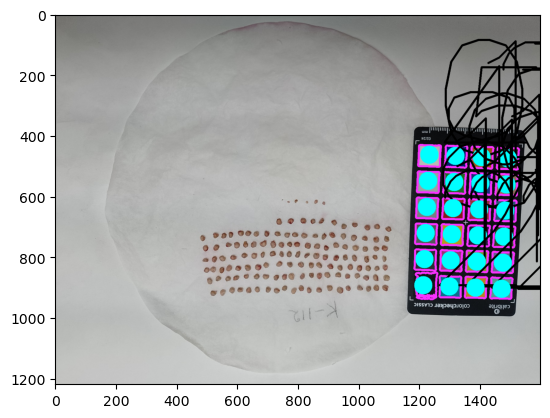

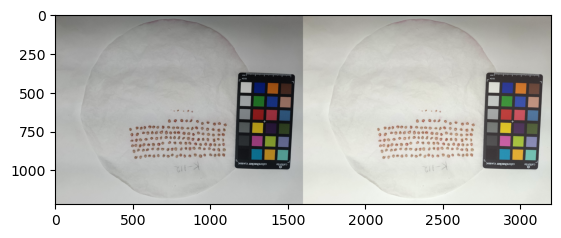

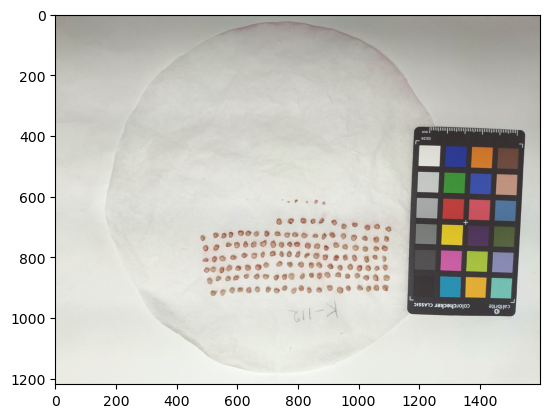

In [13]:
################################################
# Spot the card and standarize image color
card_mask = pcv.transform.detect_color_card(rgb_img=img, adaptive_method=1, block_size=51, radius=30)
headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=img, mask=card_mask)

# Define the standard color card matrix, we know what the colors of those chips should be in an "ideal" image, 
# so we will correct to those values as the TARGET c
# Look at where your white chip is in the image to determine which position your card is in (pos)

#pos     = reference value indicating orientation of the color card. The reference
       #         is based on the position of the white chip:
        #        pos = 0: bottom-left corner
        #        pos = 1: bottom-right corner
        #        pos = 2: top-right corner
        #        pos = 3: top-left corner

std_color_matrix = pcv.transform.std_color_matrix(pos=3)

img_cc = pcv.transform.affine_color_correction(rgb_img=img, 
                                               source_matrix=card_matrix,
                                               target_matrix=std_color_matrix)

pcv.plot_image(img_cc)

## Sección 2. Segmentación e identificación de objetos

### Visualización de los diversos espacios de color

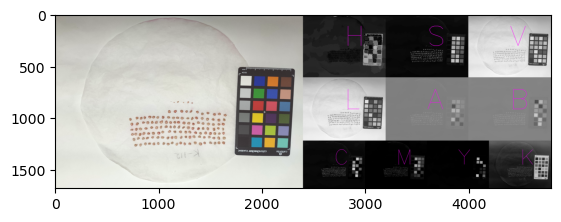

In [14]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc)

### Conversión de la imagen a escala de grises

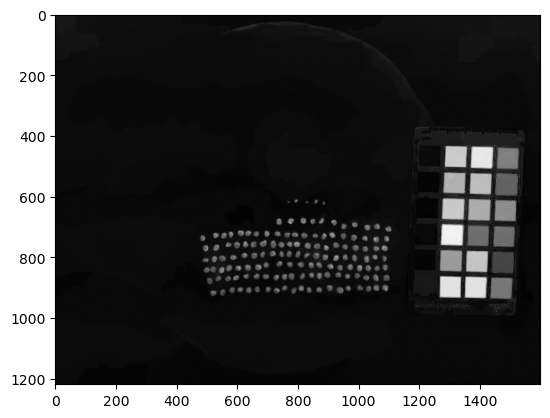

In [15]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('h', 's', or 'v')
a_img = pcv.rgb2gray_hsv(rgb_img=img_cc, channel='s')


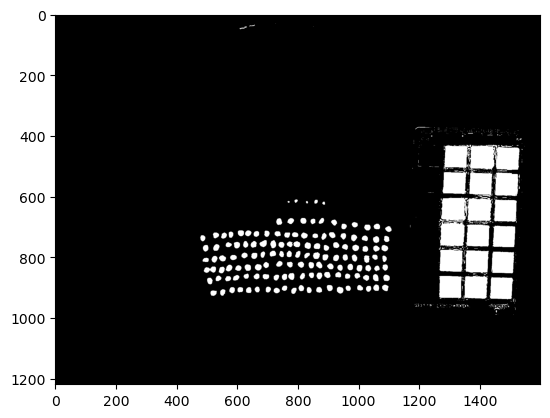

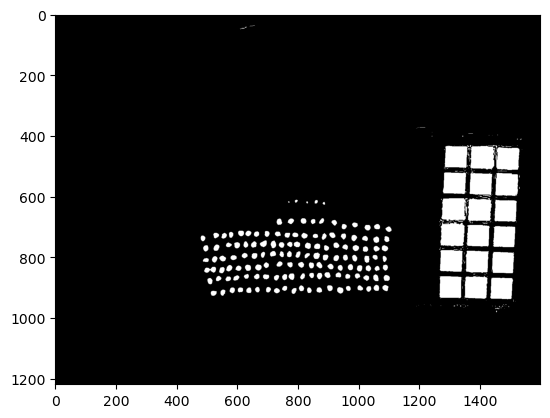

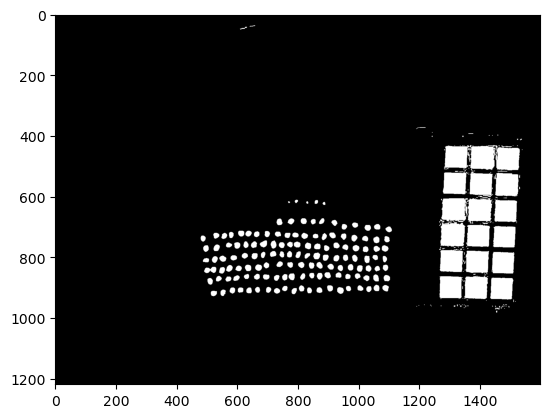

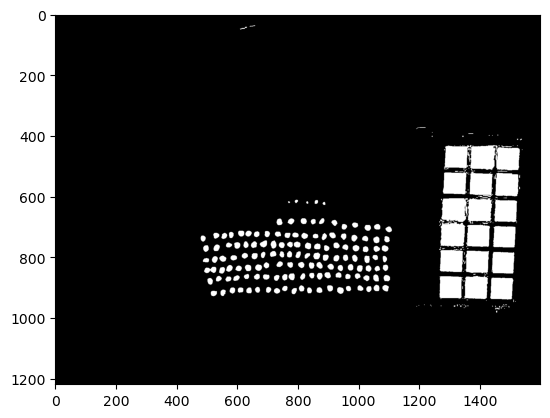

In [16]:
#Binarize, remove salt and pepper, and fill areas

th_std=pcv.threshold.binary(gray_img=a_img,threshold=36, object_type='light')
a_erode=pcv.erode(gray_img=th_std, ksize=2, i=1)
a_dilation=pcv.dilate(gray_img=a_erode, ksize=2, i=1)
#mask_fill = pcv.fill(bin_img=th_otsu, size=1)
mask_fill = pcv.fill_holes(bin_img=a_dilation)



In [17]:
#Image dimensions
print(img_cc.shape)

(1219, 1600, 3)


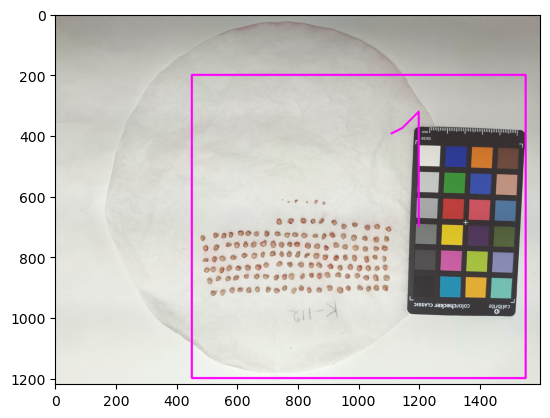

In [22]:
#ROI rectangular

roi1 = pcv.roi.rectangle(img=img_cc, x=450, y=200, h=1000, w=1100)



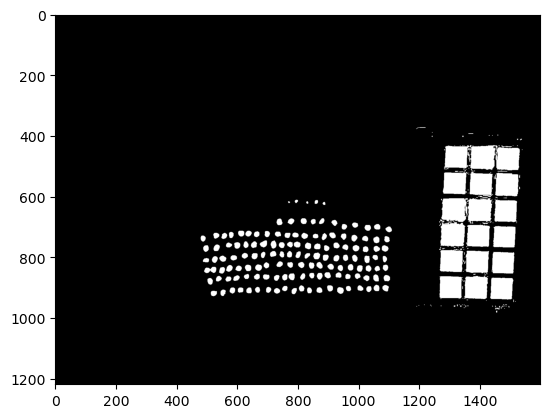

In [23]:
kept_mask  = pcv.roi.filter(mask=mask_fill, roi=roi1, roi_type='partial')


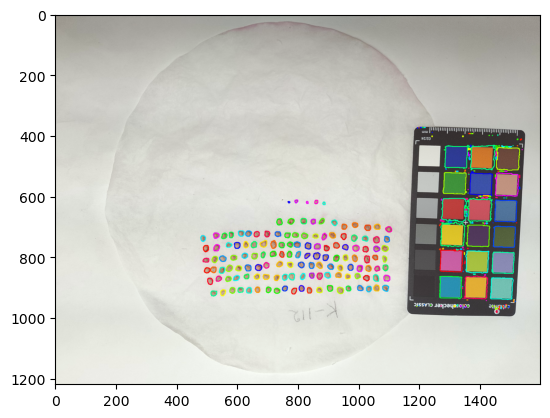

Número de semillas: 280


In [25]:
# Watershed segmentation
'''
Parameters:
rgb_img - RGB image data
mask - Binary image, single channel, object in white and background black
distance - Minimum distance of local maximum, lower values are more sensitive, and segments more objects (default: 10)
label - Optional label parameter, modifies the variable name of observations recorded. (default = pcv.params.sample_label)
'''
pcv.params.line_thickness = 2
watershed_labels=pcv.watershed_segmentation(rgb_img=img_cc, mask=kept_mask, distance=5)

#Get the number of objects
n_obj_wshed=np.unique(watershed_labels)[-1]-1
print("Número de semillas:", n_obj_wshed)
# Note: Some merged seeds have been separated

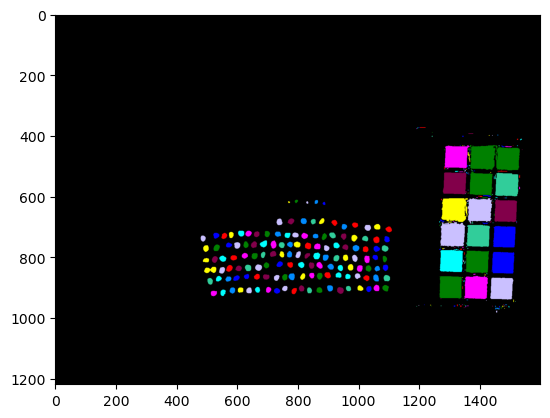

299


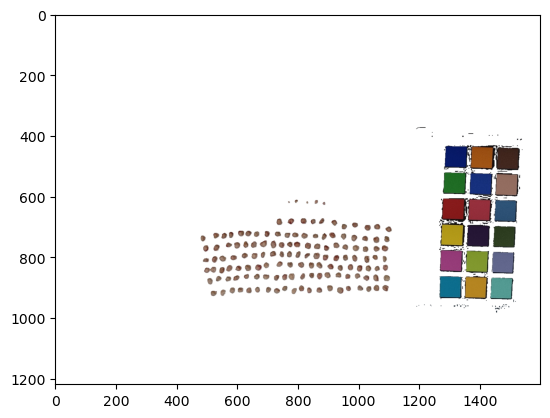

In [26]:
#Another option


#Label the objects in your region of interest and number them
#Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask so that they are separate or it will treat them as a single object

#    mask            = the clean mask you made above after making your ROI

labeled_objects, n_obj = pcv.create_labels(mask=kept_mask)

print(n_obj)

img_semillas=pcv.apply_mask(img=img, mask=kept_mask,mask_color='white')

## Sección 3. Análisis morfológico de semillas

Para esto se necesita una máscara binaria completa


### Identificación simple de objetos

La máscara binaria se usa para encontrar objetos o contornos de cada una de las semillas. A diferencia de la función find_objects, esta aplicación usa la función findContours del programa OpenCV con la entrada cv2.RETR_EXTERNAL que ignora contornos en capas. La salida de este paso se puede usar para contar semillas, pero no se puede usar como entrada para análisis de color o forma.

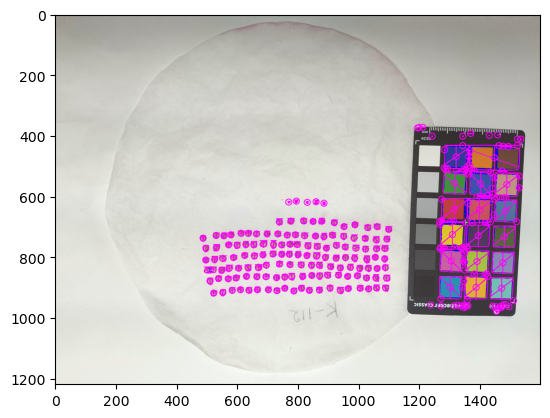

In [27]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 
# Revisar el contenido de watershed_labels con np.unique(watershed_labels) para ver cuántas etiquetas tiene:

# Importar las bibliotecas necesarias
#import numpy as np
#from plantcv import plantcv as pcv

# Suponiendo que ya se tiene la imagen y la máscara etiquetada (img_cc y watershed_labels)
'''
# Revisar el contenido de watershed_labels
unique_labels = np.unique(watershed_labels)
print(unique_labels)
np.unique(watershed_labels)

# Calcular el número de objetos (excluyendo el fondo)
n_obj_wshed = len(unique_labels) - 1
print(f"Number of objects: {n_obj_wshed}")

# Calcular el número de objetos (excluyendo el fondo)
# Hay que asegurarse de que n_obj_wshed sea el número de objetos en watershed_labels. Se puede calcular de la siguiente manera:
n_obj_wshed = len(unique_labels) - 1  # Restamos 1 para excluir el fondo (etiqueta 0)
'''
# Análisis de tamaño ejecutando la función pcv.analyze.size con los valores corregidos
analysis_image = pcv.analyze.size(img=img_cc, labeled_mask=labeled_objects, n_labels=n_obj)

# Write custom data to results file
pcv.outputs.save_results(filename="./results.json", outformat="json")

In [28]:
#Obtención Manual de los valores morfológicos 
# Obtener valores morfológicos manualmente
chip_length = 12  # mm
print('etiqueta:',pcv.params.sample_label)

print(pcv.outputs.metadata['median_color_chip_width']['value'][0])  # px

try:
    # Intentar obtener las observaciones del análisis previo
    avg_chip_size = pcv.outputs.metadata['median_color_chip_size']['value'][0]  # px
    chip_width_px = pcv.outputs.metadata['median_color_chip_width']['value'][0]  # px
    chip_height_px = pcv.outputs.metadata['median_color_chip_height']['value'][0]  # px
    print(chip_width_px)
    # Calcular el tamaño promedio del chip en píxeles y las relaciones
    chip_length_avg = (chip_width_px + chip_height_px) / 2  # cm
    ratio_length = chip_length / chip_length_avg 
    ratio_area = (chip_length ** 2) / (chip_length_avg ** 2)

    # Imprimir los valores calculados
    print(f'Área del chip en píxeles: {avg_chip_size:.1f}')
    print(f'Altura del chip en píxeles: {chip_height_px:.2f}')
    print(f'Ancho del chip en píxeles: {chip_width_px:.2f}')
    print(f'Dimensión promedio del chip en píxeles: {chip_length_avg:.2f}')
    print(f'Relación mm/píxel de la longitud promedio del chip: {ratio_length:.4f}')
    print(f'Relación mm2/píxeles de la superficie del chip: {ratio_area:.6f}')
except KeyError as e:
    print(f"Error: {e} - Asegúrate de haber corrido el análisis que genera estas observaciones antes de esta sección.")


etiqueta: default
72.2138671875
72.2138671875
Área del chip en píxeles: 4764.5
Altura del chip en píxeles: 70.18
Ancho del chip en píxeles: 72.21
Dimensión promedio del chip en píxeles: 71.20
Relación mm/píxel de la longitud promedio del chip: 0.1685
Relación mm2/píxeles de la superficie del chip: 0.028406


In [29]:
# Define the column titles
column_titles = ['archivo','n_obj','largo_mm', 'ancho_mm', 'area_mm2','perimetro_mm','solidez']

# Create an empty DataFrame with the specified columns
data = pd.DataFrame(columns=column_titles)


for i in range(n_obj):
    height=pcv.outputs.observations[f'default_{i+1}']['height']['value']*ratio_length
    width=pcv.outputs.observations[f'default_{i+1}']['width']['value']*ratio_length
    area = pcv.outputs.observations[f'default_{i+1}']['area']['value']*ratio_area
    perimeter = pcv.outputs.observations[f'default_{i+1}']['perimeter']['value']*ratio_length
    solidity = pcv.outputs.observations[f'default_{i+1}']['solidity']['value']
    data.loc[i]= [filename,i,height,width,area,perimeter,solidity]
    
archivo= ".\res_semillas.xlsx"

# Create the directory if it doesn't exist
directory = os.path.dirname(archivo)
archivo = os.path.abspath('./res_semillas.xlsx')
if directory and not os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

# Convert columns to numeric, forcing errors to NaN, then round
for col in ['largo_mm', 'ancho_mm', 'area_mm2','perimetro_mm','solidez']:
    data[col] = pd.to_numeric(data[col], errors='coerce').map(lambda x: round(x, 2) if pd.notnull(x) else x)


# Check if the file exists
if os.path.exists(archivo):
    # If the file exists, load the workbook and append to the 'Results' sheet if it exists
    with pd.ExcelWriter(archivo, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
        # Check if 'Results' sheet already exists
        if 'Results' in writer.book.sheetnames:
            # Get the maximum row in the existing sheet to append the new data below it
            startrow = writer.sheets['Results'].max_row
        else:
            # If the 'Results' sheet does not exist, start from the first row
            startrow = 0
        # Write the DataFrame to the existing file, appending data if the sheet exists <----- Key procedure!
        data.to_excel(writer, sheet_name='Results', header=startrow == 0, startrow=startrow, index=True)
else:
    # If the file does not exist, create it and write the data
    with pd.ExcelWriter(archivo, engine='openpyxl') as writer:
        data.to_excel(writer, sheet_name='Results', index=True)
data


,archivo,n_obj,largo_mm,ancho_mm,area_mm2,perimetro_mm,solidez
0,K112.jpg,0,0.34,0.51,0.17,1.01,3.00
1,K112.jpg,1,0.34,3.20,1.08,6.40,2.11
2,K112.jpg,2,0.51,0.67,0.23,1.49,2.00
3,K112.jpg,3,0.00,0.00,0.00,0.00,0.00
4,K112.jpg,4,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
294,K112.jpg,294,1.18,0.34,0.40,2.36,2.33
295,K112.jpg,295,0.51,0.34,0.17,1.01,3.00
296,K112.jpg,296,1.01,2.53,1.45,6.39,0.94
297,K112.jpg,297,0.00,0.00,0.00,0.00,0.00


In [30]:
!pip install openpyxl